# Notebook 2: Lab Final

## FaMAF, 2019

### Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

#### Grupo 14

#### Alumnos: Martín Hunziker, Claudio Sarate



In [11]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools
from sklearn.preprocessing import PolynomialFeatures


## Laboratorio:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).


In [12]:
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition

n_episodios = 5000

In [13]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [14]:
class DQN:
    def __init__(self, env, n_episodes=n_episodios, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [15]:
agent = DQN(gym.make('CartPole-v0'), n_episodes=n_episodios, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 61.97029702970297.
[Episode 200] - Mean reward 65.82587064676616.
[Episode 300] - Mean reward 65.44186046511628.
[Episode 400] - Mean reward 68.77057356608479.
[Episode 500] - Mean reward 69.56087824351297.
[Episode 600] - Mean reward 71.55241264559068.
[Episode 700] - Mean reward 74.91012838801711.
[Episode 800] - Mean reward 75.35580524344569.
[Episode 900] - Mean reward 77.25416204217537.
[Episode 1000] - Mean reward 78.24275724275724.
[Episode 1100] - Mean reward 80.08810172570391.
[Episode 1200] - Mean reward 81.44712739383847.
[Episode 1300] - Mean reward 81.8977709454266.
[Episode 1400] - Mean reward 82.09707351891507.
[Episode 1500] - Mean reward 82.57561625582944.
[Episode 1600] - Mean reward 85.24297314178638.
[Episode 1700] - Mean reward 88.2257495590829.
[Episode 1800] - Mean reward 90.62243198223209.
[Episode 1900] - Mean reward 92.83377169910574.
[Episode 2000] - Mean reward 95.2823588205897.
[Episode 2100] - Mea

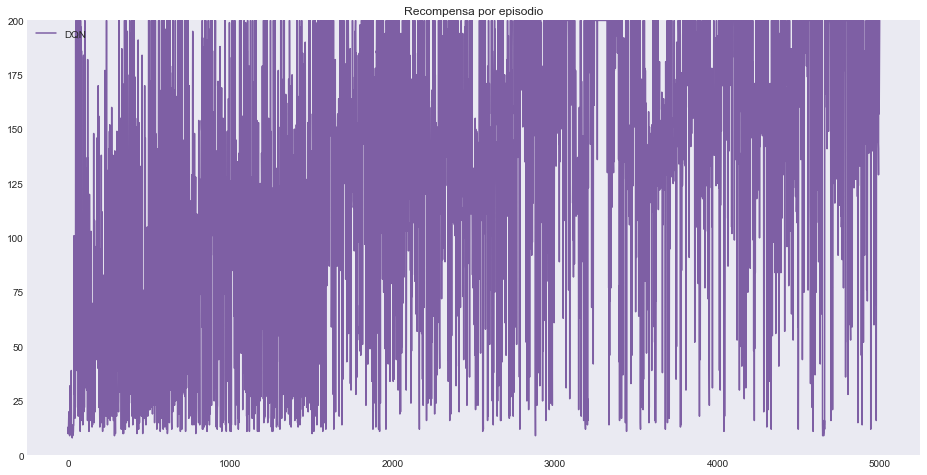

In [16]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

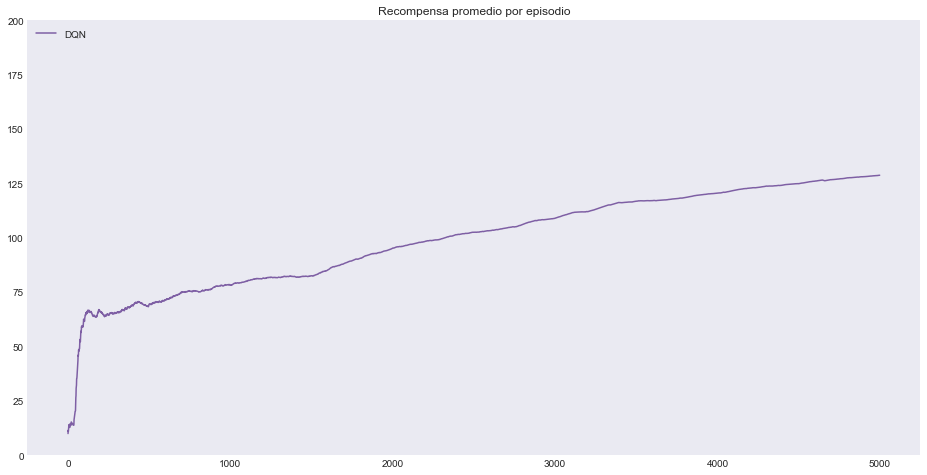

In [17]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

### Double DQN

In [18]:
class DDQN:
    def __init__(self, env, n_episodes=n_episodios, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
##### DDQN (fuente: https://github.com/Shivanshu-Gupta/Pytorch-Double-DQN)
            ### Selección de la acción del próximo estado
            _, next_state_actions = self.model(non_final_next_states).max(1, keepdim=True)
            ### Red objetivo calcula el valor de Q considerando la acción de ese estados
            next_state_values[non_final_mask] = self.target(non_final_next_states).gather(1, next_state_actions).squeeze()
            
##### DDQN fin
            
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [19]:
agent = DDQN(gym.make('CartPole-v0'), n_episodes=n_episodios, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 9.0.
[Episode 100] - Mean reward 60.08910891089109.
[Episode 200] - Mean reward 61.527363184079604.
[Episode 300] - Mean reward 54.39202657807309.
[Episode 400] - Mean reward 53.02992518703242.
[Episode 500] - Mean reward 56.93213572854292.
[Episode 600] - Mean reward 64.98502495840266.
[Episode 700] - Mean reward 67.24679029957204.
[Episode 800] - Mean reward 68.55680399500625.
[Episode 900] - Mean reward 70.22308546059934.
[Episode 1000] - Mean reward 72.27972027972028.
[Episode 1100] - Mean reward 73.16167120799274.
[Episode 1200] - Mean reward 75.26810990840966.
[Episode 1300] - Mean reward 76.74404304381245.
[Episode 1400] - Mean reward 77.51534618129907.
[Episode 1500] - Mean reward 79.41705529646902.
[Episode 1600] - Mean reward 80.35665209244222.
[Episode 1700] - Mean reward 83.66666666666667.
[Episode 1800] - Mean reward 87.01221543586897.
[Episode 1900] - Mean reward 88.50973172014729.
[Episode 2000] - Mean reward 90.43228385807096.
[Episode 2100] - 

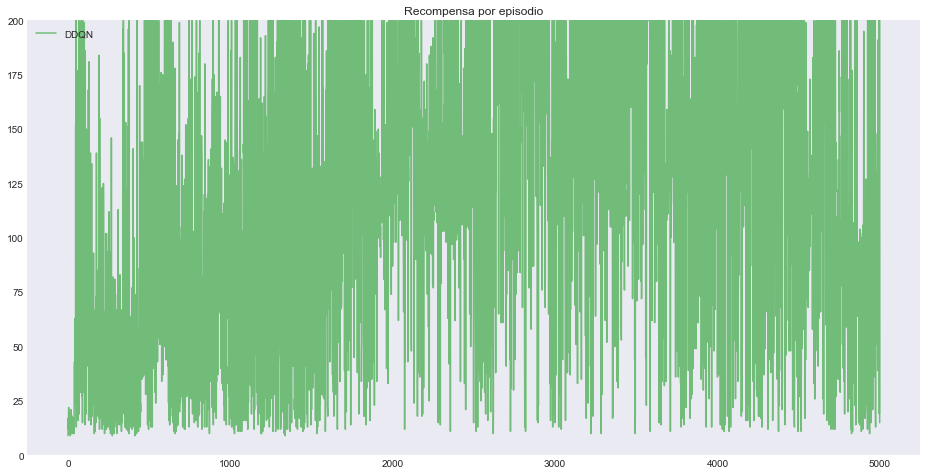

In [20]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDDQN), label='DDQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

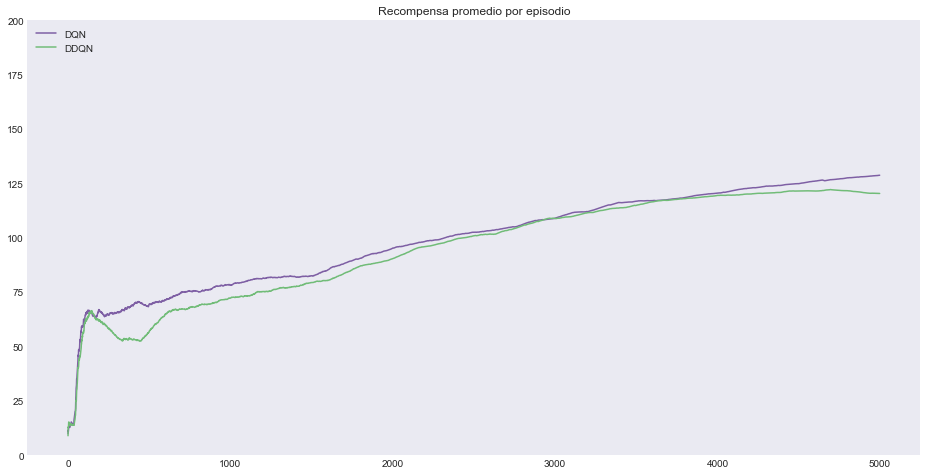

In [21]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanDDQN), label='DDQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

### Dueling DDQN

In [22]:
# fuente:
    # https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
    # PyTorch-1.x-Reinforcement-Learning-Cookbook
    
class Dueling(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Dueling, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        
        a = F.relu(self.advantage(x))
        x = self.output(x)
        return x + a - a.mean()

In [23]:
class DueDDQN:
    def __init__(self, env, n_episodes=n_episodios, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Dueling(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Dueling(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [24]:
agent = DueDDQN(gym.make('CartPole-v0'), n_episodes=n_episodios, debug=True)
scoresDueDDQN, meanDueDDQN = agent.run()

[Episode 0] - Mean reward 43.0.
[Episode 100] - Mean reward 76.38613861386139.
[Episode 200] - Mean reward 60.7363184079602.
[Episode 300] - Mean reward 58.053156146179404.
[Episode 400] - Mean reward 58.062344139650875.
[Episode 500] - Mean reward 57.812375249500995.
[Episode 600] - Mean reward 60.25623960066556.
[Episode 700] - Mean reward 62.94151212553495.
[Episode 800] - Mean reward 68.10486891385767.
[Episode 900] - Mean reward 73.00776914539401.
[Episode 1000] - Mean reward 77.8951048951049.
[Episode 1100] - Mean reward 81.49954586739328.
[Episode 1200] - Mean reward 83.76436303080766.
[Episode 1300] - Mean reward 86.15065334358187.
[Episode 1400] - Mean reward 87.9478943611706.
[Episode 1500] - Mean reward 90.56895403064624.
[Episode 1600] - Mean reward 93.60212367270456.
[Episode 1700] - Mean reward 96.48442092886538.
[Episode 1800] - Mean reward 97.12326485285952.
[Episode 1900] - Mean reward 100.35139400315623.
[Episode 2000] - Mean reward 102.17691154422789.
[Episode 2100] 

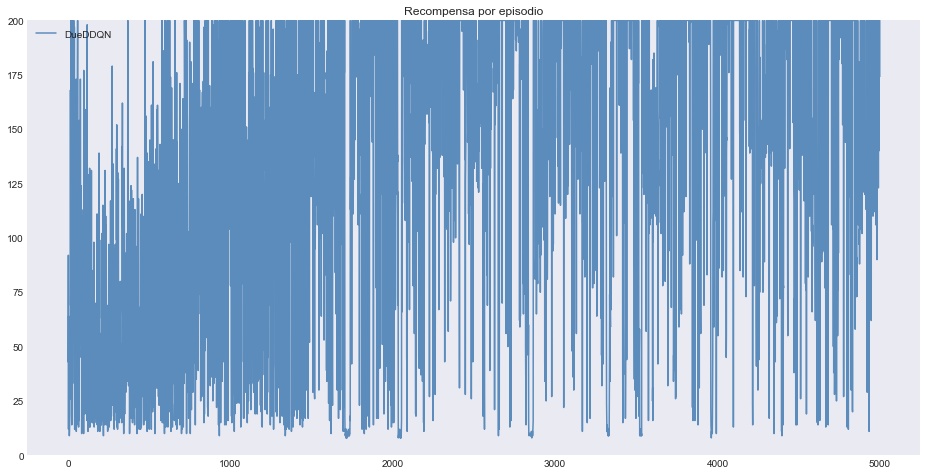

In [25]:
plt.plot(np.array(scoresDueDDQN), label='DueDDQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

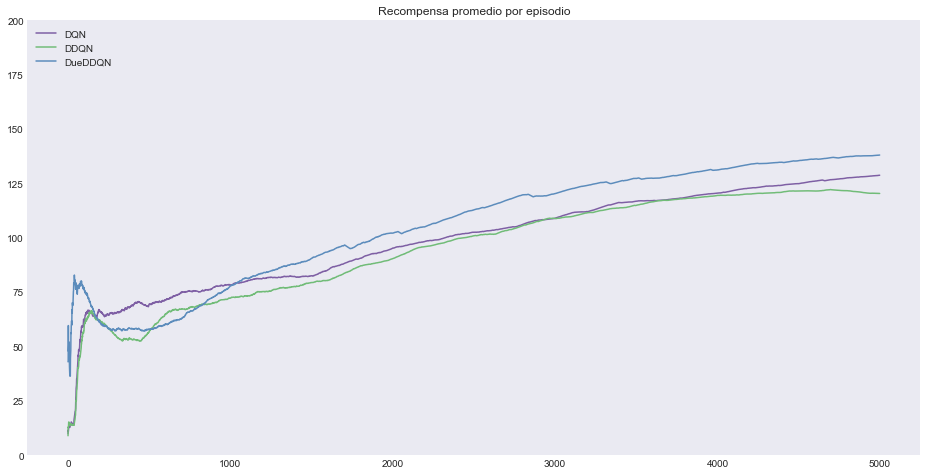

In [26]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanDDQN), label='DDQN', c='#71bc78')
plt.plot(np.array(meanDueDDQN), label='DueDDQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

### Cambiando entorno

In [27]:
agent = DQN(gym.make('Acrobot-v1'), n_episodes=n_episodios, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward -500.0.
[Episode 100] - Mean reward -320.55445544554453.
[Episode 200] - Mean reward -319.23880597014926.
[Episode 300] - Mean reward -303.43189368770766.
[Episode 400] - Mean reward -291.55610972568576.
[Episode 500] - Mean reward -277.3632734530938.
[Episode 600] - Mean reward -259.1547420965058.
[Episode 700] - Mean reward -243.9087018544936.
[Episode 800] - Mean reward -236.78152309612983.
[Episode 900] - Mean reward -227.90344062153164.
[Episode 1000] - Mean reward -226.71628371628373.
[Episode 1100] - Mean reward -220.46594005449592.
[Episode 1200] - Mean reward -218.8393005828476.
[Episode 1300] - Mean reward -213.0130668716372.
[Episode 1400] - Mean reward -210.10706638115633.
[Episode 1500] - Mean reward -207.53897401732178.
[Episode 1600] - Mean reward -204.80949406620863.
[Episode 1700] - Mean reward -202.00058788947678.
[Episode 1800] - Mean reward -199.29539144919488.
[Episode 1900] - Mean reward -201.86533403471856.
[Episode 2000] - Mean reward -

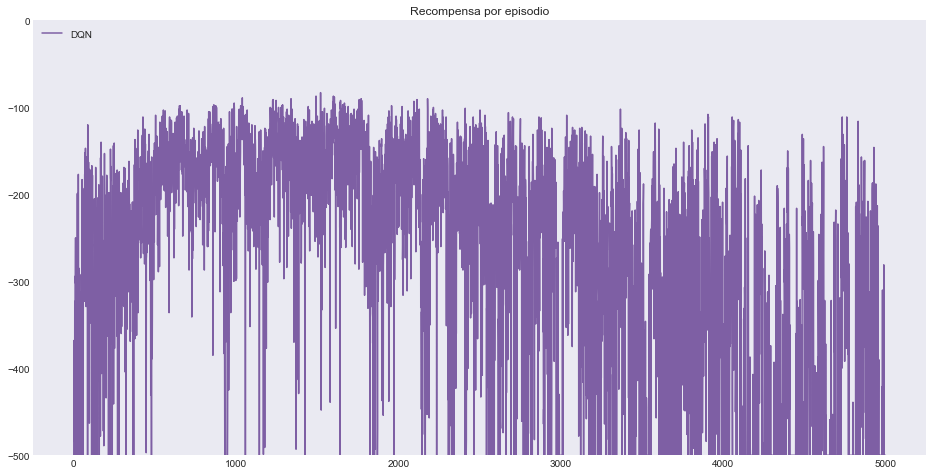

In [28]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

In [29]:
agent = DDQN(gym.make('Acrobot-v1'), n_episodes=n_episodios, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward -500.0.
[Episode 100] - Mean reward -348.6930693069307.
[Episode 200] - Mean reward -317.7910447761194.
[Episode 300] - Mean reward -294.5847176079734.
[Episode 400] - Mean reward -281.8753117206983.
[Episode 500] - Mean reward -271.07784431137725.
[Episode 600] - Mean reward -269.7753743760399.
[Episode 700] - Mean reward -259.17546362339516.
[Episode 800] - Mean reward -252.63670411985018.
[Episode 900] - Mean reward -248.00110987791342.
[Episode 1000] - Mean reward -241.86413586413587.
[Episode 1100] - Mean reward -235.20708446866485.
[Episode 1200] - Mean reward -231.78101582014986.
[Episode 1300] - Mean reward -228.532667179093.
[Episode 1400] - Mean reward -226.2241256245539.
[Episode 1500] - Mean reward -223.3530979347102.
[Episode 1600] - Mean reward -220.55340412242347.
[Episode 1700] - Mean reward -216.81716637272194.
[Episode 1800] - Mean reward -214.88284286507496.
[Episode 1900] - Mean reward -220.5097317201473.
[Episode 2000] - Mean reward -220.8

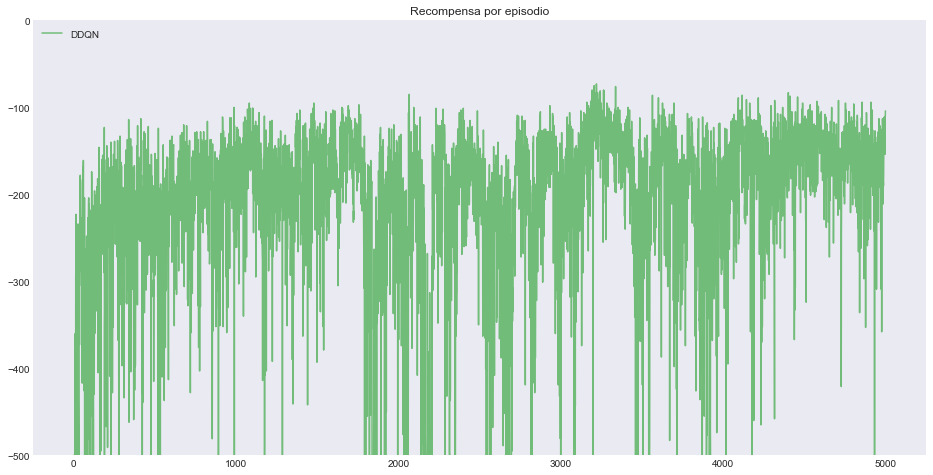

In [30]:
plt.plot(np.array(scoresDDQN), label='DDQN', c='#71bc78')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

In [31]:
agent = DueDDQN(gym.make('Acrobot-v1'), n_episodes=n_episodios, debug=True)
scoresDueDDQN, meanDueDDQN = agent.run()

[Episode 0] - Mean reward -500.0.
[Episode 100] - Mean reward -343.6930693069307.
[Episode 200] - Mean reward -278.318407960199.
[Episode 300] - Mean reward -262.69767441860466.
[Episode 400] - Mean reward -249.64089775561098.
[Episode 500] - Mean reward -239.15369261477045.
[Episode 600] - Mean reward -229.76372712146423.
[Episode 700] - Mean reward -219.80171184022825.
[Episode 800] - Mean reward -218.1947565543071.
[Episode 900] - Mean reward -215.57269700332964.
[Episode 1000] - Mean reward -214.05894105894106.
[Episode 1100] - Mean reward -213.7039055404178.
[Episode 1200] - Mean reward -213.54537885095755.
[Episode 1300] - Mean reward -209.1206764027671.
[Episode 1400] - Mean reward -205.7530335474661.
[Episode 1500] - Mean reward -203.08794137241838.
[Episode 1600] - Mean reward -199.95315427857588.
[Episode 1700] - Mean reward -199.17283950617283.
[Episode 1800] - Mean reward -199.0882842865075.
[Episode 1900] - Mean reward -197.78221988427143.
[Episode 2000] - Mean reward -197

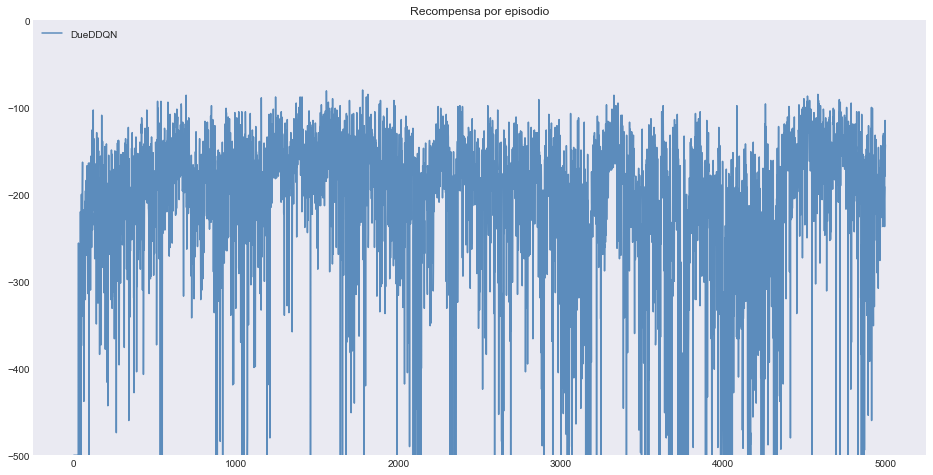

In [32]:
plt.plot(np.array(scoresDueDDQN), label='DueDDQN', c='#5c8cbc')
plt.ylim(-500, 0)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

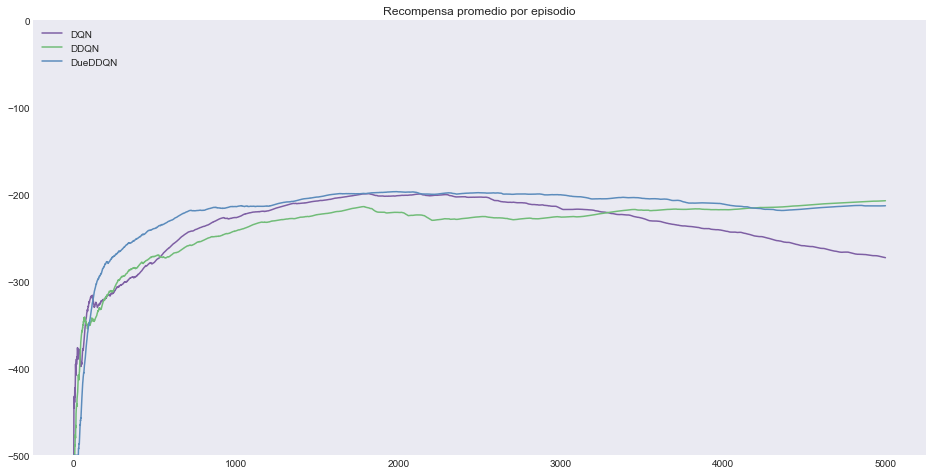

In [33]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanDDQN), label='DDQN', c='#71bc78')
plt.plot(np.array(meanDueDDQN), label='DueDDQN', c='#5c8cbc')
plt.ylim(-500, 0)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()